# HACKtheMACHINE 2021 | Track 2: Data Science, Detective Bot 

The following data dictionary describes the columns or fields of the data set and a description of the objects. This information with more detail can also be found in the `EMBER` documentation of the `features.py` file at: https://github.com/elastic/ember/blob/master/ember/features.py 

| Field Name | Description | 
|------------|-------------|
| sha256 | The Secure Hash Algorithm (SHA) is a cryptographic hash function like a signature or fingerprints for a data set. Even if one symbol is changed the algorithm will produce a different hash value. The SHA256 algorithm generates a fixed size 256-bit (32-byte) hash. The SHA256 algorithm is used to ensure you acquire the same data as the original. For exmaple, if you download something you can check if the data has not changed (due to network errors or malware injection) by comparing the hashes of your file and the original.|
| histogram | Byte histogram (count + non-normalized) over the entire binary file. The byte histogram contains 256 integer values and represent the counts of each byte value within the value. When generating model features the byte histgoram is normalized to a distribution, since file size is represented as a feature in the general file information. | 
| byteentropy | 2D byte/entropy histogram based loosely on (Saxe and Berlin, 2015). This roughly approximates the joint probability of byte value and local entropy. See Section 2.1.1 in https://arxiv.org/pdf/1508.03096.pdf for more info. The byte entropy histogram approximates the joint distriubtion p(H, X) of entropy H and byte value X. By computing the scalar entropy H for a fixed-length window and pairing it with each byte occurrence within the window. This is repeated as the window slides across the input bytes. |
| strings | Contains simple statistics about printable strings of the following: <ul><li>`numstrings`: number of strings <li> `avlength`: average length of strings <li>`printabledist`: histogram of the printable characters within those strings <li>`printables`: distinct information from byte histogram information from the byte histogram information since its derived only from strings containing at least 5 consecutive printable characters <li>`entropy`: entropy of characters across all printable strings <li>`paths` number of strings that begin with **C:** (case insensitive) that may indicate a path <li>`urls`: the number of occurences of **http://** or **https://** (case insensitive) that may indicate a URL <li>`registry`: number of occurrences of HKEY that may indicate a registry key, <li>`MZ`: number of occurrences of the short string MZ |
| general | Provides general file information. 0/1 indicates a binary output <ul><li>`size`: length of bytes <li>`vsize`: virtual size <li>`has_debug`: 0/1  <li>`exports`: 0/1 <li>`imports`: 0/1 <li>`has_relocations`: 0/1  <li>`has_resources`: 0/1 <li>`has_signature`: 0/1 <li>`has_tls`: 0/1 <li>`symbols`: 0/1 |
| header | Provides header file information on machine, architecture, OS, link and other information: <ul><li> `coeff`: [ `timestamp`, `machine`,`characteristics` ] <li> `optional`: [`subsystem`, `dll_characteristics`, `magic`, `major_image_version`, `minor_linker_version`, `major_operating_system_version`, `minor_operating_system_version`, `major_subsystem_version`, `minor_subsystem_version`, `sizeof_code`, `sizeof_headers`, `sizeof_heap_commit`]
| section | Information about section names, sizes and entropy. Uses hashing trick to summarize all this section into a feature vector. <ul><li> `imports`: [`KERNEL32.dll` : [`GetTickCount`] | 
| imports | Information about imported libraries and functions from the import address table. Note that the total number of imported functions is contained in GeneralFileInfo. |
| exports | Information about exported functions. Note that the total number of exported functions is contained in GeneralFileInfo.|
| datadirectories | Extracts size and virtual address of the first 15 data dictectories. |
| label / category | Class label indicating benign `0` or malicious `1`|

## Load Libraries

In [151]:
import numpy as np #data manipulation
import pandas as pd #data manipulation
import sklearn as sk #modeling & metrics
import seaborn as sns #visualizations
import scipy as stats #visualizations
from matplotlib import pyplot as plt #visualizations

#imputation, scaling, metrics
from sklearn import preprocessing
from sklearn import metrics
from sklearn.utils import resample
from sklearn.metrics import r2_score, classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegression


#outlier classification
from sklearn.ensemble import IsolationForest

import xgboost as xgb #xgb model
import lightgbm as lgb #lgbm model
from lightgbm import *
import re #fix error for lgbm
import hyperopt #hyperparameter tuning
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval

import shap #shap plot

import pickle 
from collections import Counter

import re
import nltk
import spacy
import gensim
import string
 
import warnings
warnings.filterwarnings('ignore')

## Requirements

The requirements file is basically this output copy pasted into a txt file

In [145]:
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

numpy==1.21.2
pandas==1.3.4
sklearn==1.0.1
seaborn==0.11.2
scipy==1.6.0
xgboost==1.5.0
lightgbm==3.2.1
re==2.2.1
hyperopt==0.2.5
shap==0.40.0
nltk==3.5
spacy==2.3.2
gensim==4.0.1


## Load Data

In [83]:
# Flattened EMBER Feature set
# Easier to feed into ML models right away
# df1 = pd.read_excel("flatten_train.xlsx")

Use pickling so you don't have to re read Excel file every time.

In [146]:
# pd.to_pickle(df1, "./data.pkl")

In [85]:
df1 = pd.read_pickle("./data.pkl")

Checking how many malware entries.

In [86]:
sum(df1['category'])

900

In [87]:
df1.shape

(18000, 714)

In [88]:
900/18000

0.05

5%, super imbalanced.

## EDA

### VISUALIZATIONS ETC SHOULD GO HERE

## Undersampling

In [89]:
majority = df1[df1.category==0] # Majority class
minority = df1[df1.category==1] # Minority class

In [90]:
majority_undersampled = resample(majority, replace=False, n_samples=900) # Randomly selects 900 records from majority to match minority class size
# New downsampled dataset
df_undersampled = pd.concat([majority_undersampled, minority])  # Minority class + sample of 900 from majority
df_undersampled.category.value_counts()

0    900
1    900
Name: category, dtype: int64

In [147]:
df = df_undersampled #make it a new df

In [92]:
X = df.drop('category', axis=1) #X is everything but the 'category' col

In [93]:
y = df['category'] #y is just the target column

In [94]:
X = X._get_numeric_data() #drop all nonnumeric ones (for now?)

In [95]:
print(X.shape, y.shape) #sanity check arrays

(1800, 693) (1800,)


## Feature Selection with ANOVA

Ideally should have selected features after heatmaps/correlation plots/distributions etc but skipped all that for now.

This is automatic but we also have no idea which ones are selected lol

In [97]:
def select_features(X_train, y_train, X_test):
    # configure to select all features
    fs = SelectKBest(score_func=f_classif, k=600) #CHANGE THIS NUMBER TO CHOOSE HOWEVER MANY FEATURES
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

Train test split 80/20

In [148]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)

In [99]:
# for i in range(len(fs.scores_[:10])):
#     print('Feature %d: %f' % (i, fs.scores_[i]))
# # plot the scores
#     plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
#     plt.show()

Now we can use X_train_fs and X_test_fs in place of X_train and X_test.

In [149]:
print(X_train_fs.shape, X_test_fs.shape)

(1440, 600) (360, 600)


In [101]:
print(y_train.shape, y_test.shape)

(1440,) (360,)


## Modeling

This function basically fits a specified model and outputs it's f1_score as well as ROC curve, can add more graphs/plots to it as well

In [103]:
def modeler(model):
    model.fit(X_train_fs, y_train) #fit specified model
    y_pred = model.predict(X_test_fs) #predict on test set
    f1 = f1_score(y_test, y_pred) #get f1 score
    print('F1 Score:', f1)
    print(metrics.confusion_matrix(y_test, y_pred))
    
    #this plots the ROC curve, play around iwth it
    from sklearn.metrics import roc_curve, auc
    fpr, tpr, thresholds = roc_curve(y_pred, y_test)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

F1 Score: 0.7513513513513514
[[129  47]
 [ 45 139]]


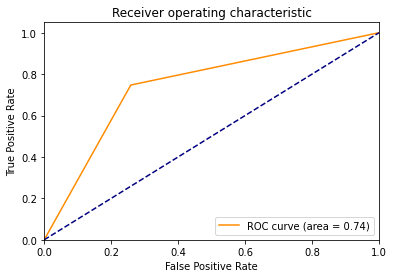

In [104]:
lr = LogisticRegression()
modeler(lr)

F1 Score: 0.8816568047337278
[[171  22]
 [ 18 149]]


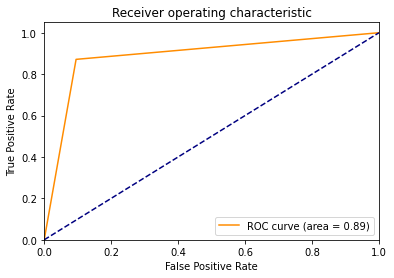

In [150]:
lgbm = lgb.LGBMClassifier()
modeler(lgbm)

[18:37:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
F1 Score: 0.8950276243093923
[[160  16]
 [ 22 162]]


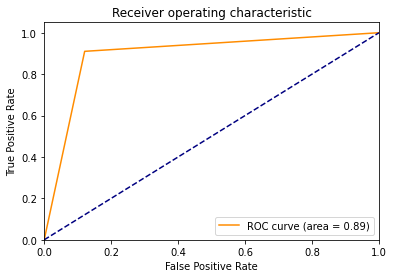

In [106]:
xgbc = xgb.XGBClassifier()
modeler(xgbc)

F1 Score: 0.8635097493036211
[[156  20]
 [ 29 155]]


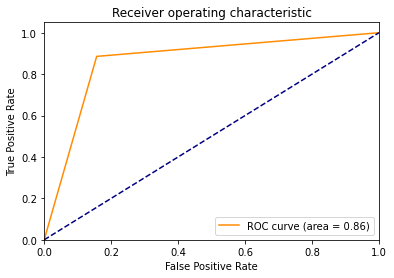

In [107]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
modeler(rf)

F1 Score: 0.6802973977695167
[[  5 171]
 [  1 183]]


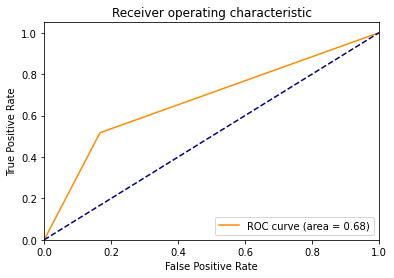

In [108]:
from sklearn.svm import SVC
svm = SVC()
modeler(svm)

F1 Score: 0.7565982404692082
[[148  28]
 [ 55 129]]


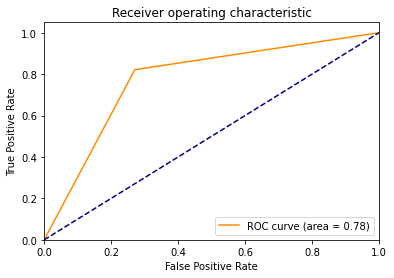

In [109]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
modeler(knn)

F1 Score: 0.8067226890756303
[[147  29]
 [ 40 144]]


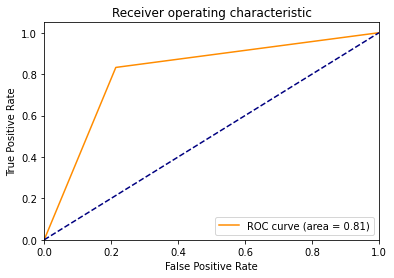

In [110]:
from sklearn import tree
dt = tree.DecisionTreeClassifier()
modeler(dt)

## Hyperparameter Optimization

LGBM seems to be one of the best so let's tuneeee

also scaling/normalizing isn't needed for gradient boosted decision trees so skip itttttt

# EVERYONE CAN TRY OPTIMIZING WITH DIFFERENT HYPERPARAMETERS LIKE IN THE COMMENTED OUT LINES, i only put these 2 to start out with

In [131]:
#hyperparameter domain to search over
hyperparam_space = {
    'num_leaves': hp.choice('num_leaves', np.arange(30, 250, 1)),
    'learning_rate': hp.quniform('learning_rate', 0, 0.3, 0.01),
#     'min_gain_to_split': hp.quniform('min_gain_to_split', 0, 15, 0.1),
#     'min_data_in_leaf': hp.choice('min_data_in_leaf', np.arange(200, 10000, 100))
#     lambda: L2 regularization (Ridge)
#     alpha: L1 regularization (Lasso)
}

Following code takes a couple minutes to run:

In [132]:
def score(params): #function to train and test different hyperparams
    model = lgb.LGBMClassifier(**params)
    model.fit(X_train_fs, y_train, early_stopping_rounds=20,
             eval_set=[(X_train_fs, y_train), (X_test_fs, y_test)])
#     y_pred = model.predict(X_test_fs)
#     score = mean_squared_error(y_test, y_pred)
    score = -cross_val_score(model, X_train_fs, y_train, cv=10, scoring='roc_auc').mean()
    print(score)
    return score
            
def optimize(trials, space): #fmin is the main library function
    best = fmin(score, space, algo=tpe.suggest, max_evals=10)
    return best
            
trials = Trials() #database that store completed hyperparameters and score
best_params = optimize(trials, hyperparam_space) #calls fmin

#finds best hyperparameters
# space_eval(hyperparam_space, best_params)

[1]	training's binary_logloss: 0.661519	valid_1's binary_logloss: 0.665858                                       
Training until validation scores don't improve for 20 rounds                                                     
[2]	training's binary_logloss: 0.631527	valid_1's binary_logloss: 0.641757                                       
[3]	training's binary_logloss: 0.604856	valid_1's binary_logloss: 0.619095                                       
[4]	training's binary_logloss: 0.579548	valid_1's binary_logloss: 0.598553                                       
[5]	training's binary_logloss: 0.556545	valid_1's binary_logloss: 0.580298                                       
[6]	training's binary_logloss: 0.534175	valid_1's binary_logloss: 0.562695                                       
[7]	training's binary_logloss: 0.513712	valid_1's binary_logloss: 0.546932                                       
[8]	training's binary_logloss: 0.495005	valid_1's binary_logloss: 0.533275              

[71]	training's binary_logloss: 0.0681214	valid_1's binary_logloss: 0.263841                                     
[72]	training's binary_logloss: 0.0660689	valid_1's binary_logloss: 0.264321                                     
[73]	training's binary_logloss: 0.0639731	valid_1's binary_logloss: 0.263609                                     
[74]	training's binary_logloss: 0.0620561	valid_1's binary_logloss: 0.263607                                     
[75]	training's binary_logloss: 0.0602575	valid_1's binary_logloss: 0.263753                                     
[76]	training's binary_logloss: 0.0583857	valid_1's binary_logloss: 0.26275                                      
[77]	training's binary_logloss: 0.0566759	valid_1's binary_logloss: 0.262227                                     
[78]	training's binary_logloss: 0.0550237	valid_1's binary_logloss: 0.262145                                     
[79]	training's binary_logloss: 0.0534826	valid_1's binary_logloss: 0.262527            

[39]	training's binary_logloss: 0.109884	valid_1's binary_logloss: 0.280364                                      
[40]	training's binary_logloss: 0.105438	valid_1's binary_logloss: 0.277724                                      
[41]	training's binary_logloss: 0.10116	valid_1's binary_logloss: 0.275677                                       
[42]	training's binary_logloss: 0.0970604	valid_1's binary_logloss: 0.274205                                     
[43]	training's binary_logloss: 0.0929124	valid_1's binary_logloss: 0.271989                                     
[44]	training's binary_logloss: 0.0893458	valid_1's binary_logloss: 0.270621                                     
[45]	training's binary_logloss: 0.0856533	valid_1's binary_logloss: 0.271016                                     
[46]	training's binary_logloss: 0.082119	valid_1's binary_logloss: 0.270181                                      
[47]	training's binary_logloss: 0.0789569	valid_1's binary_logloss: 0.268724            

[12]	training's binary_logloss: 0.108062	valid_1's binary_logloss: 0.282748                                      
[13]	training's binary_logloss: 0.0948928	valid_1's binary_logloss: 0.280698                                     
[14]	training's binary_logloss: 0.0832587	valid_1's binary_logloss: 0.276119                                     
[15]	training's binary_logloss: 0.0722606	valid_1's binary_logloss: 0.267837                                     
[16]	training's binary_logloss: 0.0630285	valid_1's binary_logloss: 0.269482                                     
[17]	training's binary_logloss: 0.0549978	valid_1's binary_logloss: 0.265166                                     
[18]	training's binary_logloss: 0.0481545	valid_1's binary_logloss: 0.264049                                     
[19]	training's binary_logloss: 0.0420966	valid_1's binary_logloss: 0.264001                                     
[20]	training's binary_logloss: 0.036865	valid_1's binary_logloss: 0.262808             

[38]	training's binary_logloss: 0.0465693	valid_1's binary_logloss: 0.270414                                     
[39]	training's binary_logloss: 0.0437246	valid_1's binary_logloss: 0.269331                                     
[40]	training's binary_logloss: 0.0408764	valid_1's binary_logloss: 0.268472                                     
[41]	training's binary_logloss: 0.0384736	valid_1's binary_logloss: 0.268373                                     
[42]	training's binary_logloss: 0.0358076	valid_1's binary_logloss: 0.265962                                     
[43]	training's binary_logloss: 0.0335679	valid_1's binary_logloss: 0.265235                                     
[44]	training's binary_logloss: 0.0314206	valid_1's binary_logloss: 0.26513                                      
[45]	training's binary_logloss: 0.0295522	valid_1's binary_logloss: 0.264837                                     
[46]	training's binary_logloss: 0.0276147	valid_1's binary_logloss: 0.267164            

[41]	training's binary_logloss: 0.0491522	valid_1's binary_logloss: 0.251462                                     
[42]	training's binary_logloss: 0.046347	valid_1's binary_logloss: 0.252439                                      
[43]	training's binary_logloss: 0.0436687	valid_1's binary_logloss: 0.251214                                     
[44]	training's binary_logloss: 0.0413113	valid_1's binary_logloss: 0.251163                                     
[45]	training's binary_logloss: 0.0389038	valid_1's binary_logloss: 0.253146                                     
[46]	training's binary_logloss: 0.0366477	valid_1's binary_logloss: 0.251659                                     
[47]	training's binary_logloss: 0.0347086	valid_1's binary_logloss: 0.250068                                     
[48]	training's binary_logloss: 0.0327942	valid_1's binary_logloss: 0.250763                                     
[49]	training's binary_logloss: 0.0308977	valid_1's binary_logloss: 0.250528            

[42]	training's binary_logloss: 0.00663445	valid_1's binary_logloss: 0.295444                                    
[43]	training's binary_logloss: 0.00596813	valid_1's binary_logloss: 0.296388                                    
[44]	training's binary_logloss: 0.00539633	valid_1's binary_logloss: 0.293598                                    
[45]	training's binary_logloss: 0.00483158	valid_1's binary_logloss: 0.296756                                    
Early stopping, best iteration is:                                                                               
[25]	training's binary_logloss: 0.0384525	valid_1's binary_logloss: 0.255329
-0.9619562142855443                                                                                              
[1]	training's binary_logloss: 0.631523	valid_1's binary_logloss: 0.639978                                       
Training until validation scores don't improve for 20 rounds                                                     
[2]	trainin

[65]	training's binary_logloss: 0.012122	valid_1's binary_logloss: 0.266205                                      
[66]	training's binary_logloss: 0.0114824	valid_1's binary_logloss: 0.26677                                      
[67]	training's binary_logloss: 0.0108171	valid_1's binary_logloss: 0.267396                                     
Early stopping, best iteration is:                                                                               
[47]	training's binary_logloss: 0.0347086	valid_1's binary_logloss: 0.250068
-0.962862958020404                                                                                               
[1]	training's binary_logloss: 0.643328	valid_1's binary_logloss: 0.650145                                       
Training until validation scores don't improve for 20 rounds                                                     
[2]	training's binary_logloss: 0.599413	valid_1's binary_logloss: 0.61241                                        
[3]	trainin

[66]	training's binary_logloss: 0.0242781	valid_1's binary_logloss: 0.258507                                     
[67]	training's binary_logloss: 0.0231602	valid_1's binary_logloss: 0.257746                                     
[68]	training's binary_logloss: 0.022129	valid_1's binary_logloss: 0.259253                                      
[69]	training's binary_logloss: 0.0212644	valid_1's binary_logloss: 0.259189                                     
[70]	training's binary_logloss: 0.0202816	valid_1's binary_logloss: 0.261347                                     
[71]	training's binary_logloss: 0.0193496	valid_1's binary_logloss: 0.263059                                     
[72]	training's binary_logloss: 0.0184675	valid_1's binary_logloss: 0.263391                                     
[73]	training's binary_logloss: 0.0176683	valid_1's binary_logloss: 0.264028                                     
[74]	training's binary_logloss: 0.0168246	valid_1's binary_logloss: 0.263438            

[13]	training's binary_logloss: 0.284803	valid_1's binary_logloss: 0.377234                                      
[14]	training's binary_logloss: 0.26907	valid_1's binary_logloss: 0.366832                                       
[15]	training's binary_logloss: 0.25436	valid_1's binary_logloss: 0.357606                                       
[16]	training's binary_logloss: 0.240222	valid_1's binary_logloss: 0.350356                                      
[17]	training's binary_logloss: 0.227334	valid_1's binary_logloss: 0.342425                                      
[18]	training's binary_logloss: 0.214285	valid_1's binary_logloss: 0.332618                                      
[19]	training's binary_logloss: 0.202558	valid_1's binary_logloss: 0.325068                                      
[20]	training's binary_logloss: 0.19197	valid_1's binary_logloss: 0.319363                                       
[21]	training's binary_logloss: 0.181639	valid_1's binary_logloss: 0.315461             

In [134]:
best_params

{'learning_rate': 0.1, 'num_leaves': 166}

In [137]:
lgbm_model = lgb.LGBMClassifier(num_leaves=best_params['num_leaves'],
                                learning_rate=best_params['learning_rate'])
lgbm_model.fit(X_train_fs, y_train)
preds = [pred[1] for pred in lgbm_model.predict_proba(X_test_fs)]
score = roc_auc_score(y_test, preds, average='weighted')
print('auc_roc score on test data: ', score)

auc_roc score on test data:  0.9614006916996047


## ^ is this good idk i think it is 

## Conclusions

## Visualizations should include ROC/AUC, SHAP PLOTS for feature importance, LGBM might also have built in feature importance plots

# scrap the below in final version

### Anomaly Detection Approach??

In [46]:
df1.shape #go back to original dataset

(18000, 694)

In [47]:
df1 = df1._get_numeric_data() #drop nonnumeric columns

#### Isolation Forest

Setting contamination rate to 5% as seen in original data, using 200 estimators.

In [48]:
iso = IsolationForest(n_estimators=200, max_samples='auto', contamination=0.05)
new_df = df1.drop(columns=['category'])
iso.fit(new_df)
new_df['anomaly_score'] = iso.predict(new_df)
new_df[new_df['anomaly_score'] == -1].shape

(900, 694)

As expected, found 900 "outliers" (in our case malware).

In [51]:
iso_df = pd.concat([new_df, df1['category']], axis=1) #join the anomaly prediction with og data
iso_df.head(10)

,histogram_0,histogram_1,histogram_2,histogram_3,histogram_4,histogram_5,histogram_6,histogram_7,histogram_8,histogram_9,...,datadirectories_12_size,datadirectories_12_virtual_address,datadirectories_13_size,datadirectories_13_virtual_address,datadirectories_14_size,datadirectories_14_virtual_address,datadirectories_15_size,datadirectories_15_virtual_address,anomaly_score,category
0,127242,9185,3818,3127,13300,1594,1781,1493,9938,1006,...,620,11711244,0,0,0,0,0,0,1,0
1,36152,2617,4120,876,1711,755,672,521,2278,325,...,340,131072,0,0,0,0,0,0,1,0
2,39986,7112,7953,6604,6542,6441,5869,6422,6224,6017,...,588,123728,0,0,0,0,0,0,1,0
3,253873,32714,22629,17500,15355,6691,10881,4258,11992,3513,...,216,282920,0,0,0,0,0,0,1,0
4,12464,1020,502,264,1918,218,262,91,846,78,...,0,0,0,0,0,0,0,0,1,0
5,17889,1281,868,642,914,138,311,148,433,82,...,0,0,0,0,0,0,0,0,1,0
6,224255,28215,12691,13046,21264,4115,3790,3590,11766,1889,...,408,1188328,0,0,0,0,0,0,1,0
7,14195,1054,778,1068,291,653,251,249,338,164,...,0,0,0,0,0,0,0,0,1,0
8,48208,3288,1441,2611,4938,313,266,635,2104,231,...,1284,230880,0,0,0,0,0,0,1,0
9,370224,37570,24575,18127,40687,15614,12405,11777,24099,5331,...,0,0,0,0,0,0,0,0,1,0


In [53]:
iso_df.groupby('anomaly_score').size() #sanity check

anomaly_score
-1      900
 1    17100
dtype: int64

In [54]:
iso_df['anomaly'] = "" #add new empty column to switch out -1 to 1 and 1 to 0

In [55]:
iso_df.loc[iso_df.anomaly_score == -1, "anomaly"] = 1
iso_df.loc[iso_df.anomaly_score == 1, "anomaly"] = 0

In [139]:
print(iso_df.groupby('anomaly').size(), iso_df.groupby('category').size())

anomaly
0    17100
1      900
dtype: int64 category
0    17100
1      900
dtype: int64


In [144]:
iso_df.head(5)

,histogram_0,histogram_1,histogram_2,histogram_3,histogram_4,histogram_5,histogram_6,histogram_7,histogram_8,histogram_9,...,datadirectories_12_virtual_address,datadirectories_13_size,datadirectories_13_virtual_address,datadirectories_14_size,datadirectories_14_virtual_address,datadirectories_15_size,datadirectories_15_virtual_address,anomaly_score,category,anomaly
0,127242,9185,3818,3127,13300,1594,1781,1493,9938,1006,...,11711244,0,0,0,0,0,0,1,0,0
1,36152,2617,4120,876,1711,755,672,521,2278,325,...,131072,0,0,0,0,0,0,1,0,0
2,39986,7112,7953,6604,6542,6441,5869,6422,6224,6017,...,123728,0,0,0,0,0,0,1,0,0
3,253873,32714,22629,17500,15355,6691,10881,4258,11992,3513,...,282920,0,0,0,0,0,0,1,0,0
4,12464,1020,502,264,1918,218,262,91,846,78,...,0,0,0,0,0,0,0,1,0,0


Calculate f1 score between new anomaly column and given category column.

In [61]:
f1_score(list(iso_df['category']), list(iso_df['anomaly']))

0.011111111111111112

### what happened???